## Milestone 2
Dataset: Open Food Facts

The dataset is downloaded and stored in the /data folder

When describing the data, in particular, you should show (non-exhaustive list):

- That you can handle the data in its size.
- That you understand what’s into the data (formats, distributions, missing values, correlations, etc.).
- That you considered ways to enrich, filter, transform the data according to your needs.
- That you have updated your plan in a reasonable way, reflecting your improved knowledge after data acquaintance. In particular, discuss how your data suits your project needs and discuss the methods you’re going to use, giving their essential mathematical details in the notebook.
- That your plan for analysis and communication is now reasonable and sound, potentially discussing alternatives to your choices that you considered but dropped.


In [42]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from geopy import distance
from geopy import Nominatim
sns.set()
sns.set(rc={'figure.figsize':(15,10)})
%pprint

Pretty printing has been turned OFF


In [2]:
data_folder = './data/'

# Data description

For our project, we are going to use several datasets:
- The [Open Food Facts](https://world.openfoodfacts.org/data) database
- The Gross Domestic Product (GDP) per country on [World Bank](https://data.worldbank.org/indicator/ny.gdp.mktp.cd)
- The Life Expectancy at birth per country on [World Bank](https://data.worldbank.org/indicator/SP.DYN.LE00.IN)

## Open Food Facts dataset

The data is in the CSV file format and can be downloaded on the Openfoodfacts website. Its size is 1.6 GB and we first decided for this milestone to download and load it using spark, as we were not sure if Pandas could handle a file of this size but as we quickly realized it was working smoothly so we will use Pandas to manipulate the data.

In [3]:
data = pd.read_csv(data_folder + 'en.openfoodfacts.org.products.csv', sep='\t', encoding='utf-8', low_memory=False)
data.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1529059204,2018-06-15T10:40:04Z,Vitória crackers,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,130 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000000123,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1535737982,2018-08-31T17:53:02Z,1535737986,2018-08-31T17:53:06Z,Sauce Sweety chili 0%,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000178,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1542456332,2018-11-17T12:05:32Z,1542456333,2018-11-17T12:05:33Z,Mini coco,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0000000000291,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1534239669,2018-08-14T09:41:09Z,1534239732,2018-08-14T09:42:12Z,Mendiants,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We see that we have a lot of columns (173), not all of them will be useful for our project so we will select the most interesting ones and drop all the others to avoid keeping unused data for computations. We first chose to remove the columns related to subjects not related to our project for better readability like ingredients concentration per product, images, related to palm_oil...

In [4]:
not_related = ['100g', 'image', 'palm_oil', 'code', 'url']
columns = [column for column in list(data.columns) if not any(st in column for st in not_related)] 
columns

['creator', 'created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime', 'product_name', 'generic_name', 'quantity', 'packaging', 'packaging_tags', 'brands', 'brands_tags', 'categories', 'categories_tags', 'categories_en', 'origins', 'origins_tags', 'manufacturing_places', 'manufacturing_places_tags', 'labels', 'labels_tags', 'labels_en', 'cities', 'cities_tags', 'purchase_places', 'stores', 'countries', 'countries_tags', 'countries_en', 'ingredients_text', 'allergens', 'allergens_en', 'traces', 'traces_tags', 'traces_en', 'serving_size', 'serving_quantity', 'no_nutriments', 'additives_n', 'additives', 'additives_tags', 'additives_en', 'nutrition_grade_uk', 'nutrition_grade_fr', 'pnns_groups_1', 'pnns_groups_2', 'states', 'states_tags', 'states_en', 'main_category', 'main_category_en']

From the remainings columns we chose the ones that interests us the most. We made our choice first by judging the usefulness of each column in relation to our project and then by regarding in more details if the data in the column was usable.

In [5]:
#TODO supprimez tous les elements de la liste qui peuvent etre inutiles
#ON DROP pas encore les rows NaNs comme on sait pas encore quelles values on va utiliser
keep = ['product_name','categories_tags','categories_en','origins_tags','manufacturing_places_tags','labels','countries_en','allergens','nutrition_grade_fr','main_category_en', 'pnns_groups_1', 'pnns_groups_2']
selected_data = data[keep]
selected_data.dtypes

product_name                 object
categories_tags              object
categories_en                object
origins_tags                 object
manufacturing_places_tags    object
labels                       object
countries_en                 object
allergens                    object
nutrition_grade_fr           object
main_category_en             object
pnns_groups_1                object
pnns_groups_2                object
dtype: object

The following columns are kept:

- product_name: name of the product
- categories_tags: categories of the product in 'tag' format
- categories_en: categories (in english)
- origins_tags: origins of ingredients in 'tag' format
- manufacturing_places_tags: place of manufacture of the product
- labels: label of the product(e.g. Bio..)
- countries_en: name of the countries in english where the product is sold
- allergens: allergens contained in the product
- nutrition_grade_fr: nutrition score given by Open Food Facts of the product
- main_category_en: main category of the product in english
- pnns_groups_1: category of te product according to the "Programme national nutrition santé" (pnns)
- pnns_groups_2: same

(tag format is the value in all lower caps, without accents and with - instead of spaces)

We save this dataframe in a csv file to speed up the loading process in our next runs.

In [6]:
selected_data.to_csv(data_folder + 'selected_data.csv')
#data = pd.read_csv(data_folder + 'en.openfoodfacts.org.products.csv', sep='\t', encoding='utf-8', low_memory=False)

Since there seems to be a lot of null values in the dataset, it can be interesting to take a look at the number of values that we have per remaining selected column.

In [7]:
selected_data.dropna()[:100]

,product_name,categories_tags,categories_en,origins_tags,manufacturing_places_tags,labels,countries_en,allergens,nutrition_grade_fr,main_category_en,pnns_groups_1,pnns_groups_2
1066,Cornish Cruncher Cheddar & Pickled Onion Hand ...,"en:plant-based-foods-and-beverages,en:plant-ba...","Plant-based foods and beverages,Plant-based fo...",royaume-uni,royaume-uni,Point Vert,"France,United Kingdom","Lait, Lait, Babeurre",c,Plant-based foods and beverages,Salty snacks,Appetizers
1143,6 Breaded Jumbo Tiger Prawns,"en:meals,en:refrigerated-foods,en:breaded-prod...","Meals,Refrigerated foods,Breaded products,Refr...",vietnam,vietnam,"Point Vert,Décongelé","France,United Kingdom","Crevettes, Crustacés, blé, Gluten",c,Meals,Composite foods,One-dish meals
1348,"grilled Cajun chicken breast, spicy wedges & s...","en:meals,en:meat-based-products,en:meals-with-...","Meals,Meat-based products,Meals with meat,Poul...","europe,royaume-uni",royaume-uni,"Peu ou pas de matière grasse,Peu de matière gr...","France,United Kingdom",Lait,a,Meals,Composite foods,One-dish meals
1355,Cornish Cove Cheddar,"en:dairies,en:fermented-foods,en:fermented-mil...","Dairies,Fermented foods,Fermented milk product...",royaume-uni,royaume-uni,Point Vert,France,Lait,d,Dairies,Milk and dairy products,Cheese
1393,Mild Cheddar with Onions & Chives,"en:dairies,en:fermented-foods,en:fermented-mil...","Dairies,Fermented foods,Fermented milk product...",royaume-uni,"royaume-uni,irelande",Point Vert,"France,United Kingdom","Fromage, Lait",d,Dairies,Milk and dairy products,Cheese
1637,British Self Raising Flour,"en:farines,en:farines-avec-levures","Farines,Farines-avec-levures",royaume-uni,royaume-uni,Végétarien,"France,United Kingdom","Wheat, Wheat",d,Farines,unknown,unknown
1644,Tomato & Sausage Pasta Sauce,"en:groceries,en:meat-based-products,en:sauces,...","Groceries,Meat-based products,Sauces,Pasta sau...",italie,italie,"Point Vert,Fabriqué en Italie",France,Céleri,b,Groceries,Fat and sauces,Dressings and sauces
2026,Made Without Wheat New York Cheesecake,"en:sugary-snacks,en:biscuits-and-cakes,en:cake...","Sugary snacks,Biscuits and cakes,Cakes,Cheesec...",royaume-uni,royaume-uni,"Sans gluten,Végétarien","France,United Kingdom","Lait, crème, Lait, crème, Lait, œufs, Lait, Lait",e,Sugary snacks,Sugary snacks,Biscuits and cakes
2167,Wrap Poulet à la Jamaïcaine,"en:meals,en:fresh-foods,en:sandwiches,en:fresh...","Meals,Fresh foods,Sandwiches,Fresh meals,Poult...",grande-bretagne,royaume-uni,Point Vert,"France,United Kingdom","blé, Gluten, blé, Lait",a,Meals,Composite foods,Sandwich
14419,Quiche Lorraine,"en:meals,en:refrigerated-foods,en:pizzas-pies-...","Meals,Refrigerated foods,Pizzas pies and quich...",united-kingdom,united-kingdom,"fr:Fait avec des œufs de poule en liberté,fr:F...","France,United Kingdom","Milk, Lait, Œufs, blé, Gluten, blé, Fromage ch...",d,Meals,Composite foods,Pizza pies and quiche


In [8]:
selected_data.count()

product_name                 673559
categories_tags              180864
categories_en                180830
origins_tags                  42723
manufacturing_places_tags     67635
labels                       102277
countries_en                 699059
allergens                     69213
nutrition_grade_fr           141843
main_category_en             180753
pnns_groups_1                257871
pnns_groups_2                263828
dtype: int64

We can also visualize the filling of columns as percentages to better visualize it :

In [9]:
selected_data.count() / max(selected_data.count()) * 100

product_name                  96.352239
categories_tags               25.872494
categories_en                 25.867631
origins_tags                   6.111501
manufacturing_places_tags      9.675149
labels                        14.630668
countries_en                 100.000000
allergens                      9.900881
nutrition_grade_fr            20.290562
main_category_en              25.856616
pnns_groups_1                 36.888303
pnns_groups_2                 37.740448
dtype: float64

For this dataset, the most important tags are the followings:`countries_en`, `origin`, `manufacturing_places` and `nutrition_grade_fr`

### `countries_en`

This column contains the names of the countries where the product is sold, separated by a comma. Without cleaning (this will be later on), the distribution of the values are as follows: 

In [25]:
def print_dis(column):
    counts = column.value_counts()
    counts = counts[:30,]
    sns.barplot(y=counts.index, x=counts.values, alpha=0.8)
    plt.show() #Alvaro comment: it doesn't show to me without it

In [11]:
selected_data.countries_en.unique()[:50]

array(['France', 'United States', 'Ireland', 'United Kingdom',
       'France,United States', 'Canada', 'Switzerland', 'Peru', 'Oman',
       'Spain', 'Germany', 'Slovenia', 'France,Germany', 'Italy',
       'Romania', 'Australia', 'Portugal', 'Israel', 'Mexico',
       'France,United Kingdom',
       'Belgium,France,Netherlands,United Kingdom', 'Guadeloupe',
       'Belgium', 'United Kingdom,United States', 'Dominican Republic',
       'Canada,United States', 'Netherlands', 'Australia,France', 'Sweden',
       'Canada,Switzerland,United States', 'Luxembourg', 'Egypt',
       'Canada,France', 'Palestinian territories', 'Haiti',
       'Mexico,United States', nan, 'France,Réunion', 'Taiwan',
       'Australia,Belgium,France,Switzerland', 'Brazil', 'France,Spain',
       'Belgium,France', 'France,En', 'France,Switzerland', 'Guatemala',
       'Australia,France,New Zealand', 'Australia,United States',
       'Saudi Arabia', 'United Arab Emirates'], dtype=object)

The values are pretty clean, with a few exceptions (fr:XX..) that we decided to drop later. As for the distribution, for now, it looks as follows:

In [12]:
print_dis(selected_data.countries_en)

Here, we are facing our first problem, while the countries have more than enough samples in it (we still need to check the distribution later on), the `origins` and `manufacturing_places` both represent less than 10% of the data. Now, if we check at the actual values of them:

### `manufacturing_places_tags`

In [13]:
selected_data.manufacturing_places_tags.unique()[:50]

array([nan, 'france', 'brossard-quebec', 'united-kingdom',
       'brossard,quebec', 'etats-unis', 'france,avranches',
       'brossars,quebec', 'thailand', 'belgien', 'net-wt',
       'las-ventas-de-retamosa,toledo-provincia,castilla-la-mancha,espana',
       'saint-yrieix,france', 'germany',
       'france,limousin,87500,saint-yrieux', 'france,87500',
       '87500,france', 'sarlat', 'pays-bas,netherlands', 'royaume-uni',
       'royaume-uni,ecosse', 'belgique', 'ireland', '87500-saint-yrieix',
       'ecosse,royaume-uni', 'black-sheep-brewery',
       'estados-unidos-americanos', 'vietnam', 'argentine', 'usa',
       '30800-st-gilles', 'chester,united-kingdom', 'uk',
       'royaume-uni,irelande', 'california,usa', 'italie', 'china',
       'angleterre', 'switzerland', 'canada', 'mexico',
       'the-hershey-company', 'cincinnati', 'united-states', 'taiwan',
       'japon', 'japan', 'topco', 'san-nicolas-de-los-garza,nuevo-leon',
       'san-francisco-california'], dtype=object)

As we can see, the values are a bit messy and not uniform at all. Now if we look at the counts of value and its distribution:

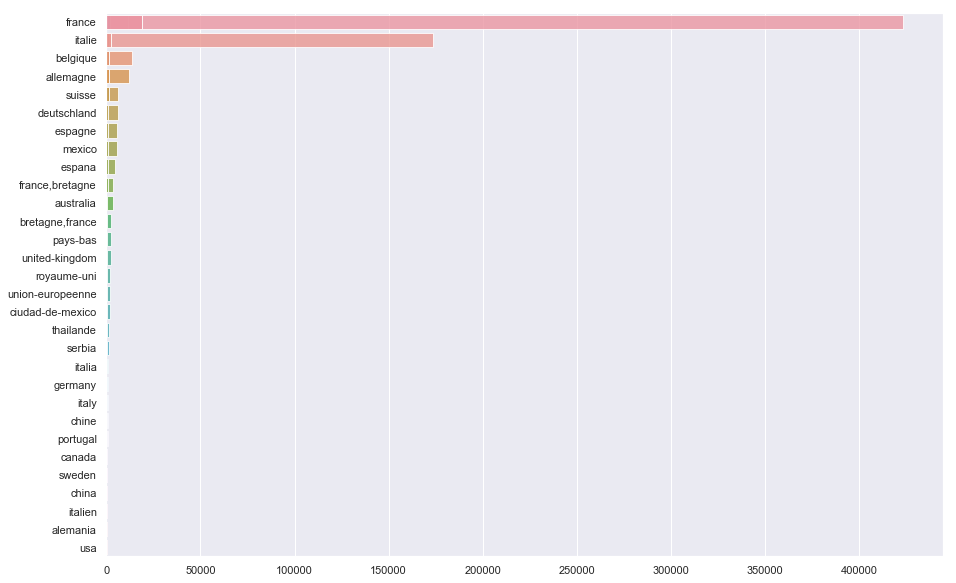

In [28]:
print_dis(selected_data.manufacturing_places_tags)

First of all, some values requires some cleaning, but we can still see the main problem: the values are dominated by the value "France", which makes our data very biased.

### `origins_tags`

Let's do the same for the origins:

In [15]:
selected_data.origins_tags.unique()[:50]

array([nan, 'france', 'quebec', 'quebec,canada', 'united-kingdom',
       'germany', 'ue', 'canada', 'mexico', 'grande-bretagne',
       'estados-unidos-americanos', 'royaume-uni', 'vietnam', 'argentine',
       'brazil', 'england', 'europe,royaume-uni',
       'easter-grangemuir-farm,pittenweem,fife,ky10-2rb,scotland,united-kingdom',
       'royaume-uni,hors-royaume-uni', 'perou', 'italie', 'tibet',
       'espagne,royaume-uni', 'united-states', 'madagascar', 'taiwan',
       'japon', 'usa', 'estados-unidos', 'california', 'estero',
       'atlantique-nord-ouest,canada', 'suisse', 'saudi',
       'estados-unidos-de-america', 'britain,british-chicken', 'italy',
       'francia', 'fougerolles,france', 'ancaster,ontario,canada',
       'scotland', 'royaume-uni,west-sussex', 'malaisie', 'washington,usa',
       'e-u-a', 'etats-unis', 'californie,etats-unis', 'new-zealand',
       'sicile,italie', 'indetermine'], dtype=object)

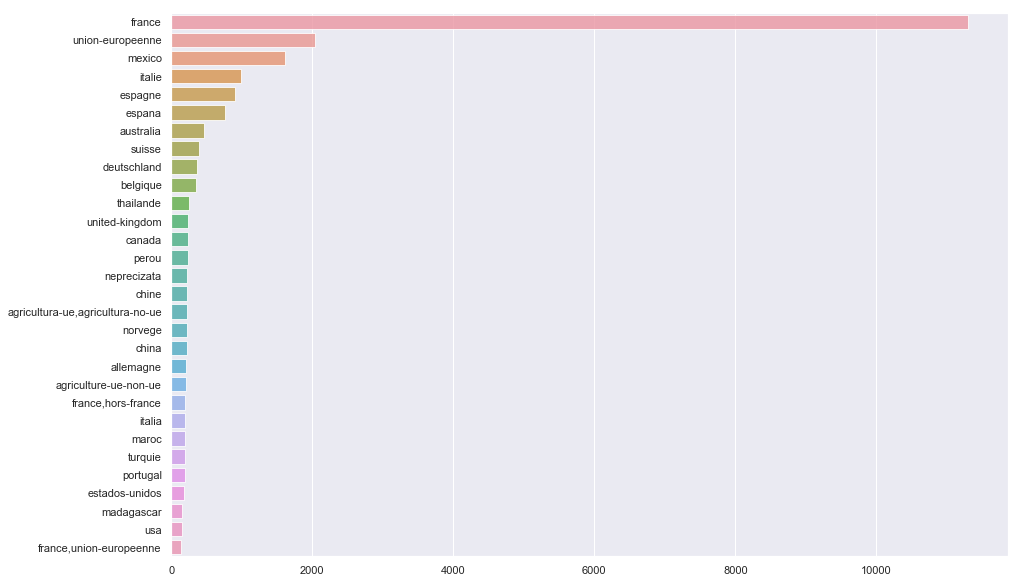

In [29]:
print_dis(selected_data.origins_tags)

We encounter here the same problem. Our origins and manufacturing places are heavily biased because of an overwhelming number of food originating from France.

In [47]:
a = selected_data['origins_tags'].dropna(how='all').str.lower()
a[a.str.contains('suisse')].count()

574

In [48]:
#DEMO de comment on peut chercher les pays d'origine qu'on veut
a = selected_data['origins_tags'].dropna(how='all').str.lower()
a[a.str.contains('france')].count()

16612

We are now facing another problem, all the tags are not normalized and a lot of them are even invalid ("mer", postal code, or in other languages). 

### `nutrition_score_fr`

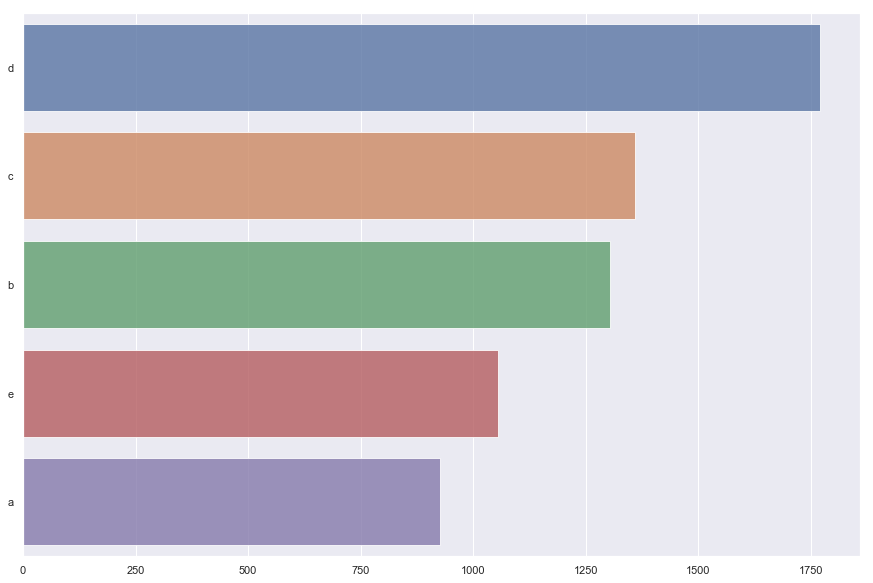

In [30]:
print_dis(selected_data.dropna().nutrition_grade_fr)

In [20]:
mapping_nutrition = {'a': 5, 'b': 4, 'c': 3, 'd': 2, 'e': 1, 'f': 0}
mapped = selected_data.dropna().replace({'nutrition_grade_fr': mapping_nutrition})
mapped.head()

,product_name,categories_tags,categories_en,origins_tags,manufacturing_places_tags,labels,countries_en,allergens,nutrition_grade_fr,main_category_en,pnns_groups_1,pnns_groups_2
1066,Cornish Cruncher Cheddar & Pickled Onion Hand ...,"en:plant-based-foods-and-beverages,en:plant-ba...","Plant-based foods and beverages,Plant-based fo...",royaume-uni,royaume-uni,Point Vert,"France,United Kingdom","Lait, Lait, Babeurre",3,Plant-based foods and beverages,Salty snacks,Appetizers
1143,6 Breaded Jumbo Tiger Prawns,"en:meals,en:refrigerated-foods,en:breaded-prod...","Meals,Refrigerated foods,Breaded products,Refr...",vietnam,vietnam,"Point Vert,Décongelé","France,United Kingdom","Crevettes, Crustacés, blé, Gluten",3,Meals,Composite foods,One-dish meals
1348,"grilled Cajun chicken breast, spicy wedges & s...","en:meals,en:meat-based-products,en:meals-with-...","Meals,Meat-based products,Meals with meat,Poul...","europe,royaume-uni",royaume-uni,"Peu ou pas de matière grasse,Peu de matière gr...","France,United Kingdom",Lait,5,Meals,Composite foods,One-dish meals
1355,Cornish Cove Cheddar,"en:dairies,en:fermented-foods,en:fermented-mil...","Dairies,Fermented foods,Fermented milk product...",royaume-uni,royaume-uni,Point Vert,France,Lait,2,Dairies,Milk and dairy products,Cheese
1393,Mild Cheddar with Onions & Chives,"en:dairies,en:fermented-foods,en:fermented-mil...","Dairies,Fermented foods,Fermented milk product...",royaume-uni,"royaume-uni,irelande",Point Vert,"France,United Kingdom","Fromage, Lait",2,Dairies,Milk and dairy products,Cheese


## Gross Domestic Product and Life Expectancy dataset

In [32]:
gdp = pd.read_csv(data_folder + 'GDP.csv')
#gdp.head()

In [33]:
gdp = gdp[['Country Name', 'Country Code', '2017']].dropna()
gdp.columns = ['countries_en', 'country_code', '2017']
gdp.head()

,countries_en,country_code,2017
1,Afghanistan,AFG,2.081530e+10
2,Angola,AGO,1.242094e+11
3,Albania,ALB,1.303935e+10
4,Andorra,AND,3.012914e+09
5,Arab World,ARB,2.591047e+12


We kept the following columns:
- countries_en: name of the countries in english
- country_code: country codes
- 2017: 2017 GDP values (most recent available)

We plot the distribution:

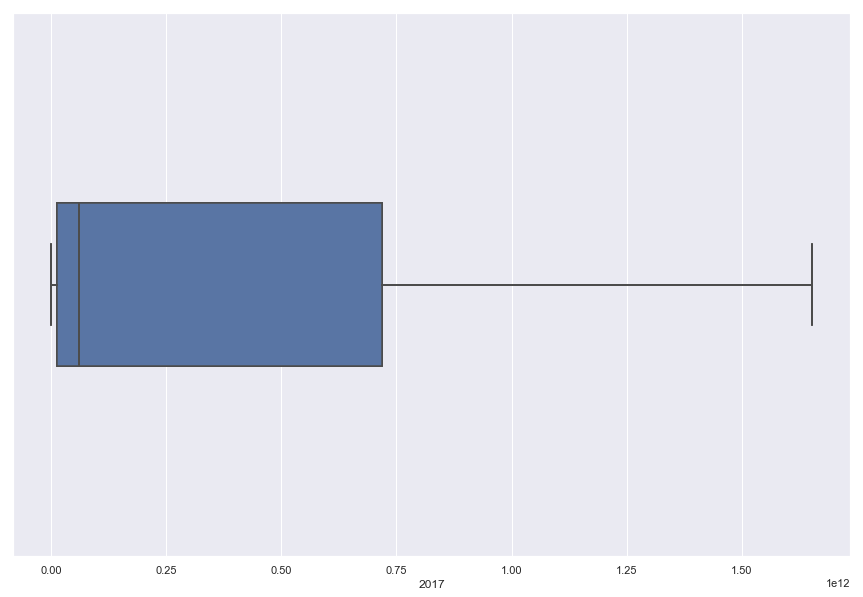

In [38]:
sns.boxplot(x=(gdp['2017']), showfliers=False, width=0.3)
#plt.show()

There are some extreme offliers that crush the boxplots, the statistical description of the values are the follows:

In [39]:
gdp['2017'].describe()

count    2.340000e+02
mean     2.848129e+12
std      9.177562e+12
min      3.973132e+07
25%      1.150900e+10
50%      5.944777e+10
75%      7.175373e+11
max      8.068379e+13
Name: 2017, dtype: float64

We also want to observe an eventual relation between food quality and health. For this we also found on the same website the LE.csv file from which we can obtain the life expectancy per country. We will use the data for year 2016 as it is the most recent available year (year 2017 has no value) :

In [40]:
le = pd.read_csv(data_folder + 'LE.csv')
#le.head()

In [41]:
le = le[['Country Name', 'Country Code', '2016']].dropna()
le.columns = ['countries_en', 'country_code', '2016']
le.head()

,countries_en,country_code,2016
0,Aruba,ABW,75.867000
1,Afghanistan,AFG,63.673000
2,Angola,AGO,61.547000
3,Albania,ALB,78.345000
5,Arab World,ARB,71.198456


In [27]:
sns.boxplot(x=(le['2016']), showfliers=False, width=0.3)

In [28]:
le['2016'].describe()

count    245.000000
mean      71.992486
std        7.515606
min       51.835000
25%       66.683000
50%       73.473000
75%       77.203000
max       84.226829
Name: 2016, dtype: float64

In [121]:
result = gdp.join(le, lsuffix='_caller', rsuffix='_other')

In [130]:
result['2017'].corr(result['2016'])

0.16017123003591782

# Geopy

In order to compute the impact of the globalization we desire to compute the distance between countries. For that we decided to use GeoPy. A dataset that holds the localization of the cities and countries around the world.

In [51]:
d = distance.distance
g = Nominatim(user_agent="specify_your_app_name_here")
_, fr = g.geocode('france')
_, uk = g.geocode('united-kingdom')
print(fr)
print(uk)
print(d(fr, uk))

(46.603354, 1.8883335)
(54.7023545, -3.2765753)
971.5166387817475 km


To measure distances between countries we can either decide to use the capitals per country as their point of reference or we can use the name of the country e.g. France to get the center of the country as a point of reference.

By using the values found in the columns of origins and countries we can directly compute the distance in kilometers between countries. We decided that to keep fairness, we will measure the distances between the centers of the countries. 

To compute its impact in the environment we should use the carbon footprint. However, this data is inconsistent and very small inside our dataset. So, as a general carbon footprint we will compute the average of the ones we have in the dataset to use it as a unit per kilometer for each product.

In [114]:
avg_footprint = data['carbon-footprint_100g'].sum()/data['carbon-footprint_100g'].count()
avg_footprint

269.95324249709307

# Cleaning the data

## Open Food Facts dataset

In [97]:
data_selected = pd.read_csv(data_folder + 'selected_data.csv')
data_selected.head()

,Unnamed: 0,product_name,categories_tags,categories_en,origins_tags,manufacturing_places_tags,labels,countries_en,allergens,nutrition_grade_fr,main_category_en,pnns_groups_1,pnns_groups_2
0,0,Vitória crackers,NaN,NaN,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN
1,1,Cacao,NaN,NaN,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN
2,2,Sauce Sweety chili 0%,NaN,NaN,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN
3,3,Mini coco,NaN,NaN,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN
4,4,Mendiants,NaN,NaN,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN


## Countries

In [100]:
def faster(df, col):
    s = df[col].str.split(',', expand=True).stack()
    i = s.index.get_level_values(0)
    df2 = df.loc[i].copy()
    df2[col] = s.values
    return df2

In [145]:
data_countries = data_selected[data_selected['countries_en']!=""]
data_countries = data_selected[data_selected['origins_tags']!=""]
data_countries = data_selected[data_selected['manufacturing_places_tags']!=""]

In [146]:
data_countries = faster(data_countries, 'countries_en')

In [147]:
data_countries = faster(data_countries, 'origins_tags')

ValueError: Length of values does not match length of index

In [144]:
data_countries = faster(data_countries, 'manufacturing_places_tags')

ValueError: Length of values does not match length of index

In [143]:
data_countries.count()

Unnamed: 0                   56979
product_name                 56740
categories_tags              54749
categories_en                54692
origins_tags                 56979
manufacturing_places_tags    37309
labels                       37752
countries_en                 56916
allergens                    18400
nutrition_grade_fr           39291
main_category_en             54678
pnns_groups_1                54072
pnns_groups_2                56020
dtype: int64

# Plans for the Project

# Societal aspects of food 

## Relations between food quality and general health

We would first like to discover if for a given country the quality of the food that is consumed there can have an influence on the global health of this country. To this purpose we will use the nutritional coefficients grades, (maybe the average number of nocive additives) and the life expectancy data.

In [ ]:
#TODO correlation coefficients between average nutritional and expectancy per country

## Relations between food quality and general wealth

We will also analyze the possible links between average food quality and the global wealth of a country. For this we will again use  the nutritional coefficients grades, (maybe the average number of nocive additives) and the GDPs.

# Impacts of Globalization

## Consequences of globalization, case study on countries

We will take the example of concrete countries like Switzerland and France to observe how the globalization impacts the food quality of these countries. We will try to observe if the food imported from abroad to these countries is globally healthier or not than the one produced in those countries, by using data like nutritional coefficients and additives.

## Ecological footprint of globalization

We will analyze the ecological footprint of the food transport. What distance does the food travel before reaching countries like the ones we will study ? How can we quantify this footprint ?  We will use for this data from TODO FIND DATA SOURCE FOR THIS

# Conclusion

We will try to bring all our observations and analysis to make a global statement on the effects of globalization on the world and more specifically on countries like Switzerland. Do globalization impacts our environnement ? Is this globalization of food good for our health ? Should we try to eat more local or continue on this path ?